<a href="https://colab.research.google.com/github/ruhanaazam/gp_transfer/blob/main/Transfer_Coh2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!pip install gpytorch
!pip install botorch

In [3]:
!cd drive

In [4]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import gpytorch
from botorch.utils.transforms import normalize, standardize
import matplotlib.pyplot as plt

from botorch.utils.transforms import normalize_indices
from botorch.models import SingleTaskGP, MixedSingleTaskGP

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def surfacePlot(model, title = "Your Function" ,n=900):
    '''
    Plots your (true or estimated) coheritability function.
    model: function that takes in two wavelength and outputs coh2 (estimate)
    n: n**2 is the number of points to plot the surface
    '''
    # Generate data for the plot
    x1 = torch.linspace(0, 1, n)
    x2 = torch.linspace(0, 1, n)
    X1, X2 = torch.meshgrid(x1, x2)
    X = torch.stack([X1.reshape((-1)),X2.reshape((-1))]).T

    Z = model(X.to(device))#.cpu().detach().numpy()

    # Create a contour plot
    plt.contourf(X1, X2, Z.reshape(n, n), cmap='viridis')
    plt.colorbar(label='Function Value')

    #plot top 1%
    #threshold = np.percentile(Z, 99)
    #threshold = torch.kthvalue(Z.flatten(), int(0.99 * n * n)).values
    #plt.contour(X1, X2, Z.reshape(n, n), levels=[threshold], colors='red', linewidths=2)

    # Add labels and title
    plt.xlabel('Wavelength 1')
    plt.ylabel('Wavelength 2')
    plt.title(title)

    # Show the plot
    plt.show()
    return

In [6]:
def getTaskID(trait, crop="Sorghum"):
    assert crop == "Sorghum", "Does not handles ids for from that are not Sorghum yet."
    ids = {"narea": 1, "sla": 2, "pn": 3, "ps": 4}
    return ids[trait]

In [7]:
def loadTasks(tasks):
    taskData = []
    for trait in tasks:
        #read raw task file
        data = pd.read_csv(f"/content/drive/My Drive/Colab Notebooks/Transfer_Coh2/data/{trait}_coh2.csv")
        data = torch.tensor(data.values)

        #format data for supervised training, each row (taskid, wave1, wave2, coh2)
        n = torch.ones(data.shape[0], dtype=torch.float32)
        col_index =  torch.arange(data.shape[0], dtype=torch.float32)
        col_index = torch.outer(n, col_index)
        row_index = col_index.T

        #stack wave1, wave2 and coh2 tensors together
        task_ids = torch.ones(data.shape) * getTaskID(trait)
        flat_data = torch.stack([task_ids.flatten(), col_index.flatten(), row_index.flatten(), data.flatten()])
        flat_data = flat_data.T

        #remove all rows with nans
        nan_mask = torch.isnan(flat_data)
        nan_in_rows = torch.any(nan_mask, dim=1)
        clean = flat_data[~nan_in_rows]

        taskData.append(clean)

    #combine all tasks
    all_tasks = torch.cat(taskData)
    return all_tasks[:, :3], all_tasks[:, -1]

In [8]:
#Load data (by tasks)
X, Y = loadTasks(["narea"])

#Split into train and validation sets
seed = 1234
split = 1
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=split, random_state=seed)

# Convert NumPy arrays to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float64)
y_train = torch.tensor(y_train, dtype=torch.float64)
x_test = torch.tensor(x_test, dtype=torch.float64)
y_test = torch.tensor(y_test, dtype=torch.float64)

<ipython-input-8-759bb2eb36db>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float64)
<ipython-input-8-759bb2eb36db>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float64)
<ipython-input-8-759bb2eb36db>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float64)
<ipython-input-8-759bb2eb36db>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

In [9]:
# #check that your can load the kernel
# temp = torch.load('/content/drive/My Drive/Colab Notebooks/Transfer_Coh2/kernel/mixedKernel.csv')
# x1 = torch.tensor([[0.5, 1, 1]], dtype=torch.float64)
# x2 = torch.tensor([[0.5, 1, 1]], dtype=torch.float64)
# temp(x1,x2).to_dense().detach()

In [10]:
#subsection of data
N = 3000

#normalize continuous inputs, standardize outputs
d_xtrain = x_train[:N,0].reshape(-1,1) #discrete part
c_xtrain = normalize(x_train[:N, 1:], torch.tensor([[0,0],[2150,2150]])) #continous part
x_train = torch.cat([c_xtrain, d_xtrain], dim=1)
y_train  = standardize(y_train[:N]).reshape(-1,1).numpy()

#define continous and categorical indices
d = x_train.shape[-1]
cat_dims= [-1]
cat_dims = normalize_indices(indices=cat_dims, d=x_train.shape[-1]) #categorical column number
ord_dims = sorted(set(range(d)) - set(cat_dims)) #continuous column number

#define kernel(s) for dataset above
#rbf kerenl (can be used for single task)
kernel = gpytorch.kernels.RBFKernel(ard_num_dims=2) #todo: change this to mixed kernel
kernel.lengthscale = torch.tensor([0.03, 0.035])

rbf = kernel.__call__
def k(x, y, h=rbf):
  x = torch.tensor(x, dtype=torch.float64)
  y = torch.tensor(y, dtype=torch.float64)
  return h(x, y).numpy()

#mixed kernel (for multi-task)
#TODO: load a kernel instead here instead....
def mk(x1, x2):
  x1 = torch.tensor(x1, dtype=torch.float64)
  x2 = torch.tensor(x2, dtype=torch.float64)
  cat_dims = [-1]
  #model = MixedSingleTaskGP(x1, torch.ones(len(x1)).reshape(-1,1).double(), cat_dims=cat_dims) #replace this with loaded kernel
  #cov = model.covar_module(x1,x2).to_dense()
  covar_module = torch.load('/content/drive/My Drive/Colab Notebooks/Transfer_Coh2/kernel/mixedKernel.csv')
  cov = covar_module(x1,x2).to_dense()
  return cov.detach().numpy()

Run Exact Mean Solution with Mixed Kernel.

In [11]:
# #sanity check: mixed kernel should ouput ~1.86 with same input, only for default MixedSingleTaskGP kernel, w/ no hp tuning
# x1 = torch.tensor([[0.5, 1, 1]], dtype=torch.float64)
# x2 = torch.tensor([[0.5, 1, 1]], dtype=torch.float64)
# mk(x1, x2)

In [12]:
noise_scale = 0.04

#solve (exact) kernel regression
#K = k(x_train, x_train, rbf)
K = mk(x_train, x_train)
alpha_exact = np.linalg.solve(K + noise_scale ** 2 * np.eye(N), y_train)

def exactMean(x_pred):
  return mk(x_pred, x_train) @ alpha_exact

<ipython-input-10-532ab9c25bad>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x1 = torch.tensor(x1, dtype=torch.float64)
<ipython-input-10-532ab9c25bad>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x2 = torch.tensor(x2, dtype=torch.float64)


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
<ipython-input-10-532ab9c25bad>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x1 = torch.tensor(x1, dtype=torch.float64)
<ipython-input-10-532ab9c25bad>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x2 = torch.tensor(x2, dtype=torch.float64)


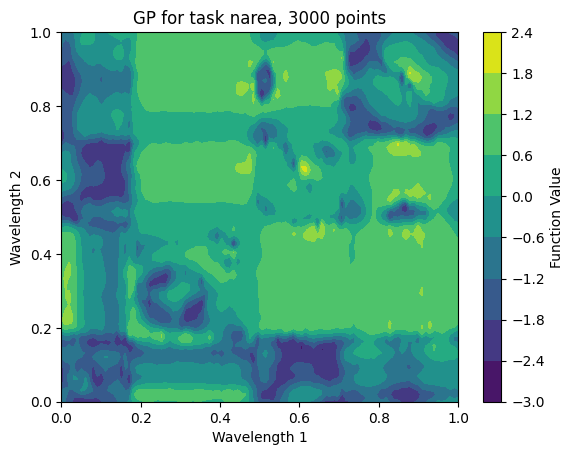

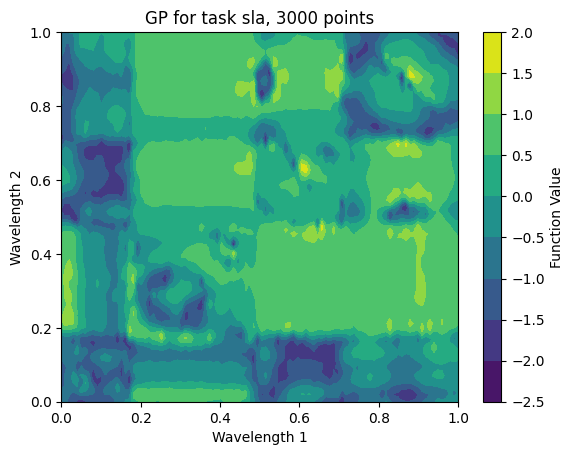

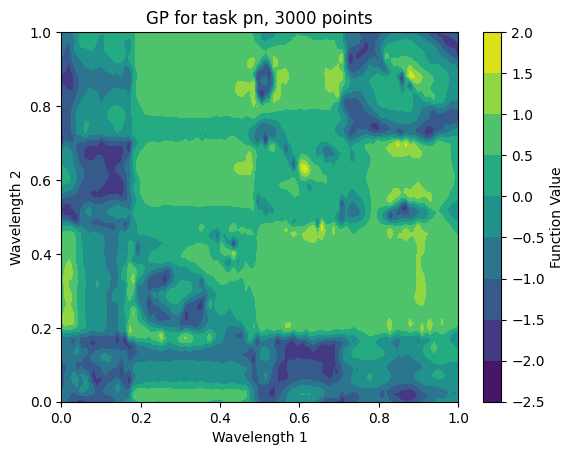

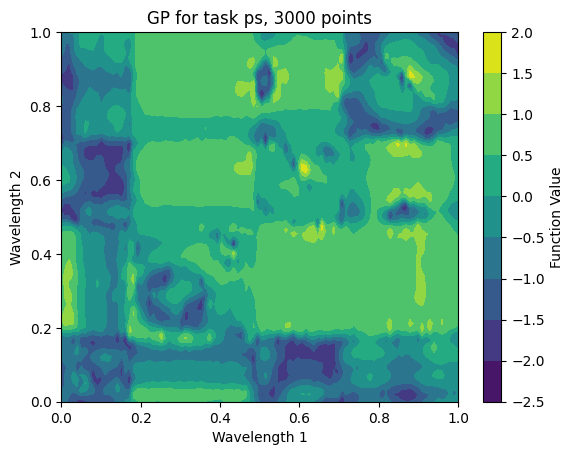

In [13]:
for task in ["narea", "sla", "pn", "ps"]:
  def modelWrapper(X):
    id = getTaskID(task)
    id_vector = id * torch.ones((X.shape[0], 1))
    inp = torch.cat([X, id_vector], dim=1)
    return exactMean(inp)

  surfacePlot(modelWrapper, title=f"GP for task {task}, {len(x_train)} points", n=100)

In [14]:
#check diff between task from exactMean solution
temp = []
for task in ["narea", "sla", "pn", "ps"]:
  n=100
  x1 = torch.linspace(0, 1, n)
  x2 = torch.linspace(0, 1, n)
  X1, X2 = torch.meshgrid(x1, x2)
  X = torch.stack([X1.reshape((-1)),X2.reshape((-1))]).T
  id = getTaskID(task)
  id_vector = id * torch.ones((X.shape[0], 1))
  inp = torch.cat([X, id_vector], dim=1)
  temp.append(exactMean(inp))

diff1 = "narea"
diff2 = "ps"

def diffWrapper(X):
  id_vector1 = getTaskID(diff1) * torch.ones((X.shape[0], 1))
  id_vector2 = getTaskID(diff2) * torch.ones((X.shape[0], 1))
  inp1 = torch.cat([X, id_vector1], dim=1)
  inp2 = torch.cat([X, id_vector2], dim=1)
  out1 = exactMean(inp1)
  out2 = exactMean(inp2)
  diff = abs(out1 - out2) < 0.001
  return diff

<ipython-input-10-532ab9c25bad>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x1 = torch.tensor(x1, dtype=torch.float64)
<ipython-input-10-532ab9c25bad>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x2 = torch.tensor(x2, dtype=torch.float64)


<ipython-input-10-532ab9c25bad>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x1 = torch.tensor(x1, dtype=torch.float64)
<ipython-input-10-532ab9c25bad>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x2 = torch.tensor(x2, dtype=torch.float64)


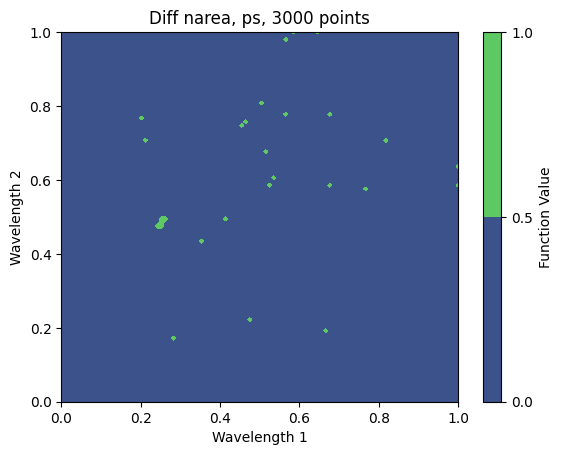

In [15]:
sum(abs(temp[0] - temp[1]) < 0.01), len(temp[0])
surfacePlot(diffWrapper, title=f"Diff {diff1}, {diff2}, {len(x_train)} points", n=100)

In [16]:
lr = 0.0001
momentum = 0.9
polyak = 1e-2
iterations = 3500
B = 10

noise_scale = 0.04

#intialize variables
alpha = np.zeros((N,))
alpha_polyak = np.zeros((N,))
v = np.zeros((N,))

#dual objective
def g(params, idx, k, N, B, noise_scale):
    K_batch = k(x_train[idx], x_train)
    grad = np.zeros((N,))
    grad[idx] = K_batch @ params - y_train[idx].reshape(-1) + (noise_scale ** 2) * params[idx]
    return (N / B) * grad

#update parameter
def update(params_polyak, velocity, params, idx, k,  N, B, noise_scale):
    grad = g(params=params, idx=idx, k=k, N=N, B=B, noise_scale=noise_scale)
    velocity = momentum * velocity - lr * grad
    params = params + velocity
    params_polyak = polyak * params + (1.0 - polyak) * params_polyak
    return params, params_polyak, velocity

In [17]:
k = mk
for i in range(iterations):
    idx = np.random.choice(N, size=(B,), replace=False)
    alpha, alpha_polyak, v = update(params_polyak=alpha_polyak,
                                    velocity=v,
                                    params=alpha,
                                    idx=idx, k=k, N=N, B=B,noise_scale=noise_scale)

<ipython-input-10-532ab9c25bad>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x1 = torch.tensor(x1, dtype=torch.float64)
<ipython-input-10-532ab9c25bad>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x2 = torch.tensor(x2, dtype=torch.float64)


<ipython-input-10-532ab9c25bad>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x1 = torch.tensor(x1, dtype=torch.float64)
<ipython-input-10-532ab9c25bad>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x2 = torch.tensor(x2, dtype=torch.float64)


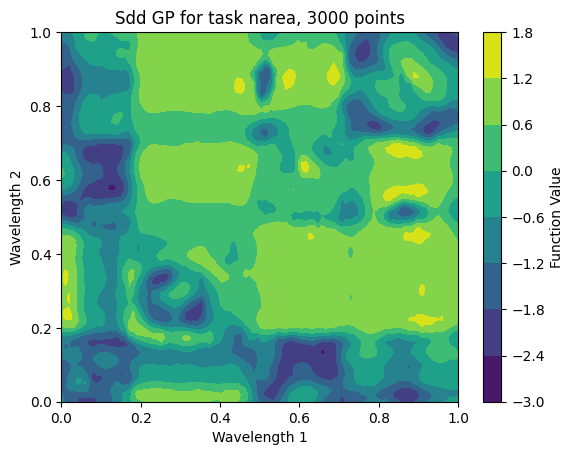

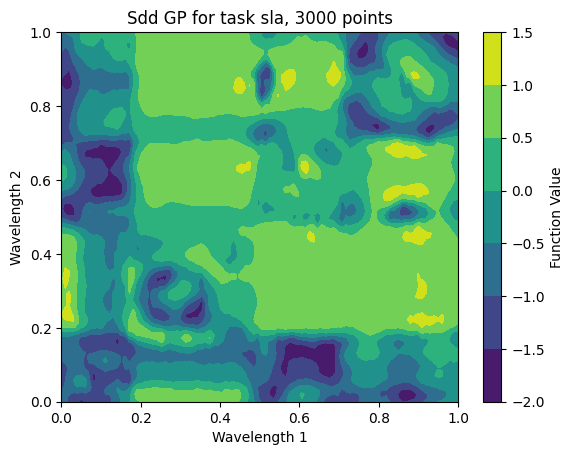

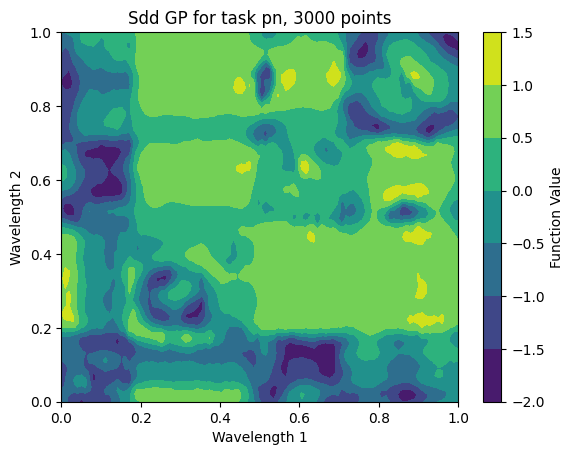

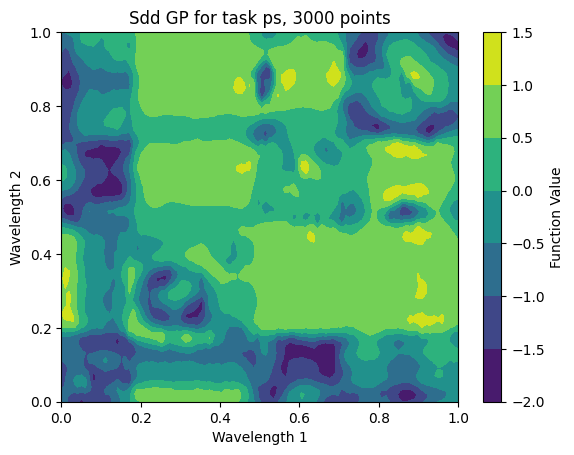

In [21]:
for task in ["narea" , "sla", "pn", "ps"]:
  def sddWrapper(X):
    id = getTaskID(task)
    id_vector = id * torch.ones((X.shape[0], 1))
    inp = torch.cat([X, id_vector], dim=1)
    return k(inp, x_train) @ alpha_polyak #sdd mean

  surfacePlot(sddWrapper, title=f"Sdd GP for task {task}, {len(x_train)} points", n=100)

In [22]:
def sddWrapper(X):
    return k(X, x_train) @ alpha_polyak #sdd mean

#check diff between task from exactMean solution
temp = []
for task in ["narea", "sla", "pn", "ps"]:
  n=100
  x1 = torch.linspace(0, 1, n)
  x2 = torch.linspace(0, 1, n)
  X1, X2 = torch.meshgrid(x1, x2)
  X = torch.stack([X1.reshape((-1)),X2.reshape((-1))]).T
  id = getTaskID(task)
  id_vector = id * torch.ones((X.shape[0], 1))
  inp = torch.cat([X, id_vector], dim=1)
  temp.append(sddWrapper(inp))

diff1 = "narea"
diff2 = "ps"

def diffWrapper(X):
  id_vector1 = getTaskID(diff1) * torch.ones((X.shape[0], 1))
  id_vector2 = getTaskID(diff2) * torch.ones((X.shape[0], 1))
  inp1 = torch.cat([X, id_vector1], dim=1)
  inp2 = torch.cat([X, id_vector2], dim=1)
  out1 = exactMean(inp1)
  out2 = exactMean(inp2)
  diff = abs(out1 - out2) < 0.001
  return diff

<ipython-input-10-532ab9c25bad>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x1 = torch.tensor(x1, dtype=torch.float64)
<ipython-input-10-532ab9c25bad>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x2 = torch.tensor(x2, dtype=torch.float64)


In [30]:
sum(abs(temp[0] - temp[3]) < 0.001), len(temp[0])

(42, 10000)